In [ ]:
from sklearn.preprocessing import OneHotEncoder

# Initialize OneHotEncoder
ohe = OneHotEncoder(sparse=False)

# Apply One-Hot Encoding to the 'TAG' column and convert it to an array
labels = ohe.fit_transform(df[['TAG']])

# 'labels' is now a NumPy array where each row corresponds to the one-hot encoded vector for the 'TAG'
print(labels.shape)  # This will print the shape of the encoded label array


In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [ ]:
x_input_ids = np.zeros(len(df), 512)
x_attn_mask = np.zeros(len(df), 512)

In [ ]:
def generate_training_data(df, input_id_arr, attn_mask_arr, tokenizer):
    for i, text in enumerate(df['cleaned_data']): 
        # Tokenize the text
        tokenized_text = tokenizer.encode_plus( 
            text, 
            max_length=512,  # Ensure tokenized sentence is up to 512 tokens
            padding='max_length',  # Pads to the max length of 512 tokens
            truncation=True,  # Truncates sentences longer than 512 tokens
            return_tensors='tf'#'np'  # Return NumPy arrays for compatibility
        )
        # Fill in the arrays with tokenized input_ids and attention masks
        input_id_arr[i, :] = tokenized_text['input_ids'][0]
        attn_mask_arr[i, :] = tokenized_text['attention_mask'][0]
    
    return input_id_arr, attn_mask_arr


In [ ]:
X_input_ids, X_attn_masks = generate_training_data(df, input_id_arr, attn_mask_arr, tokenizer)

print(input_id_arr.shape)  # Output: (num_samples, 512)
print(attn_mask_arr.shape)  # Output: (num_samples, 512)

In [ ]:
import tensorflow as tf

# Assuming X_input_ids, X_attn_masks, and labels are NumPy arrays
# Example: X_input_ids.shape = (num_samples, 512), labels.shape = (num_samples,)

# Create a TensorFlow dataset from the input arrays
dataset = tf.data.Dataset.from_tensor_slices((X_input_ids, X_attn_masks, labels))

# Take a sample (first batch) from the dataset
for input_ids, attn_mask, label in dataset.take(1):
    print(f"Input IDs: {input_ids.numpy()}")
    print(f"Attention Mask: {attn_mask.numpy()}")
    print(f"Label: {label.numpy()}")

In [ ]:
# Add prefetching to the dataset
dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)

In [ ]:
# Total number of samples in the dataset
num_samples = len(df)

# Calculate train size (80% of the dataset)
train_size = int(num_samples * 0.8)  # Calculate 80% of total samples

# Create training and testing datasets
train_dataset = dataset.take(train_size)  # First 80% for training
test_dataset = dataset.skip(train_size)    # Remaining 20% for testing

# Print the sizes of the datasets
print(f"Training dataset size: {len(list(train_dataset))}")  # Convert to list to count
print(f"Testing dataset size: {len(list(test_dataset))}")    # Convert to list to count

# Check the sizes of the datasets
train_size_count = sum(1 for _ in train_dataset)
test_size_count = sum(1 for _ in test_dataset)

print(f"Training dataset size: {train_size_count}")
print(f"Testing dataset size: {test_size_count}")

In [ ]:
import tensorflow as tf
from transformers import TFBertModel

# Load pre-trained BERT model
model = TFBertModel.from_pretrained('bert-base-cased')

# Define the input layers
input_ids = tf.keras.layers.Input(shape=(512,), name='input_ids', dtype='int32')
attn_masks = tf.keras.layers.Input(shape=(512,), name='attention_mask', dtype='int32')

# Get the BERT embeddings (pooled output [CLS] token)
bert_embds = model(input_ids, attention_mask=attn_masks)[1]

# Dropout layer after BERT output
dr_layer = tf.keras.layers.Dropout(0.3, name='dropout1')(bert_embds)

# Intermediate Dense layer
intermediate_layer = tf.keras.layers.Dense(512, activation='relu', name='intermediate_layer1')(dr_layer)

# Another Dropout layer after intermediate layer
dr_layer = tf.keras.layers.Dropout(0.3, name='dropout2')(intermediate_layer)

# Output layer for classification (9 classes, softmax activation)
output_layer = tf.keras.layers.Dense(9, activation='softmax', name='output_layer')(dr_layer)

# Define the classification model
classification_model = tf.keras.Model(inputs=[input_ids, attn_masks], outputs=output_layer)

# Show the model summary
classification_model.summary()


In [ ]:
classification_model.compile(optimizer=tf.keras.optimizers.Adam(),
                             loss='categorical_crossentropy',
                             metrics=[tf.keras.metrics.Precision()]))
# metrics=[tf.keras.metrics.Precision(), 'accuracy']

#EarlyStoppping
#early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2)
#classification_model.fit(train_dataset, validation_data=test_dataset, epochs=3, callbacks=[early_stopping])


In [ ]:
classification_model.fit(train_dataset, validation_data=test_dataset, epochs=3, batch_size=32)

In [ ]:
# Evaluate the model on the test dataset
test_loss, test_accuracy = classification_model.evaluate(test_dataset)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")


# Evaluate the model on the training dataset
train_loss, train_accuracy = classification_model.evaluate(train_dataset)
print(f"Train Loss: {train_loss}, Train Accuracy: {train_accuracy}")

In [ ]:
# Save the trained model
classification_model.save('bert_classification_model.h5')

##### confusion matrix for train dataset

In [ ]:
# Load the model
from tensorflow.keras.models import load_model
NewsClassificationBERTModel = load_model('bert_classification_model.h5')

# Prepare out-of-time data using the tokenizer
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

def prepare_data(input_text, tokenizer):
    token = tokenizer.encode_plus(
        input_text,
        max_length=512,
        padding='max_length',
        truncation=True,
        return_tensors='tf'
    )
    return {
        'input_ids': tf.cast(token.input_ids, tf.float32),  # Corrected tf.float64 to tf.float32 for consistency
        'attention_mask': tf.cast(token.attention_mask, tf.float32)
    }

# Prediction function
def make_predictions(model, processed_data, classes=list(np.unique(df['TAG']))):
    probs = model.predict([processed_data['input_ids'], processed_data['attention_mask']])[0]
    return classes[np.argmax(probs)]

# Test data example (ensure test_data is preprocessed similarly to training data)
test_excerpts = test_data['cleaned_data'].to_list()  # Assuming 'cleaned_data' is the column in test_data

# Making predictions on out-of-time data
predicted = []
for i in test_excerpts:
    processed_data = prepare_data(i, tokenizer)
    result = make_predictions(NewsClassificationBERTModel, processed_data)
    predicted.append(result)

# Adding predictions to the test_data DataFrame
test_data['predicted'] = predicted


In [2]:

import numpy as np
ab = []
ab.extend(range(10))
ab

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

In [6]:
input_ids = np.array([[101, 7592, 2082, 2003, 102, 0, 0, 0]])  # Example input IDs
attention_mask = np.array([[1, 1, 1, 1, 1, 0, 0, 0]])  # Example attention mask
input_ids.shape[0]

0


#### Method to retrive original texts using the input_id's and attenstion_mask

### END-to-END Code

In [7]:
!pip install transformers


# # Step 1: Load the pre-trained BERT tokenizer
# tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

# # Step 2: Load the pre-trained BERT model
# bert_model = TFBertModel.from_pretrained('bert-base-cased')

     ---------------------------------------- 9.9/9.9 MB 389.5 kB/s eta 0:00:00
     ------------------------------------ 436.4/436.4 kB 827.6 kB/s eta 0:00:00
     ---------------------------------------- 2.3/2.3 MB 423.8 kB/s eta 0:00:00
     ------------------------------------ 286.1/286.1 kB 631.2 kB/s eta 0:00:00
     ------------------------------------ 179.3/179.3 kB 433.4 kB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2022.7.1
    Uninstalling fsspec-2022.7.1:
      Successfully uninstalled fsspec-2022.7.1


### Functions

In [158]:
len(train_true_labels)
train_true_labels

['Sports',
 'Health',
 'Sports',
 'Politics',
 'Politics',
 'Finance',
 'Minerals',
 'Politics',
 'Cinema',
 'Minerals',
 'Minerals',
 'Finance',
 'Finance',
 'Finance',
 'Health',
 'Cinema',
 'Cinema',
 'Minerals',
 'Cinema']

array([[0., 0., 0., 0., 0., 1.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [1., 0., 0., 0., 0., 0.]])

In [168]:
labels_in_sample_encoded_df.loc[train_indexes]

,0,1,2,3,4,5
4,0.0,0.0,0.0,0.0,0.0,1.0
26,0.0,0.0,1.0,0.0,0.0,0.0
0,0.0,0.0,0.0,0.0,0.0,1.0
12,0.0,0.0,0.0,0.0,1.0,0.0
11,0.0,0.0,0.0,0.0,1.0,0.0
17,0.0,1.0,0.0,0.0,0.0,0.0
20,0.0,0.0,0.0,1.0,0.0,0.0
13,0.0,0.0,0.0,0.0,1.0,0.0
6,1.0,0.0,0.0,0.0,0.0,0.0
21,0.0,0.0,0.0,1.0,0.0,0.0


In [166]:
list(ohe.categories_[0])

['Cinema', 'Finance', 'Health', 'Minerals', 'Politics', 'Sports']

In [172]:
pred_labels_indices = np.argmax(labels_in_sample_encoded_df.loc[train_indexes].values, axis=1)
    # 3. Convert indices to actual class names
classes = ohe.categories_[0]
pred_labels = classes[pred_labels_indices]
pred_labels

array(['Sports', 'Health', 'Sports', 'Politics', 'Politics', 'Finance',
       'Minerals', 'Politics', 'Cinema', 'Minerals', 'Minerals',
       'Finance', 'Finance', 'Finance', 'Health', 'Cinema', 'Cinema',
       'Minerals', 'Cinema'], dtype=object)

In [69]:
#DAta Cleaning

def clean_text(text):
    # 1. Lowercase the text
    #text = text.lower()
    # 2. Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    # 3. Remove HTML tags
    text = re.sub(r'<.*?>', '', text)
    # 4. Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    # 5. Remove numbers
    
    text = re.sub(r'\d+', '', text)
    # 6. Remove stopwords
    text = ' '.join([word for word in text.split() if word not in stop_words])
    # 7. Remove extra whitespaces
    text = re.sub(r'\s+', ' ', text).strip()
    return text

def clean_column(df, col_name):
    # Apply the clean_text function to each entry in the specified column
    return df[col_name].apply(clean_text)

#$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
# Function to generate input IDs and attention masks
def generate_data(df, input_id_arr, attn_mask_arr):
    
    for i, text in enumerate(df['cleaned_data']): 
        # Tokenize the text
        tokenized_text = tokenizer.encode_plus(
            text, 
            max_length=50,  # Ensure tokenized sentence is up to 512 tokens
            padding='max_length',  # Pads to the max length of 512 tokens
            truncation=True,  # Truncates sentences longer than 512 tokens
            return_tensors='np'  # Return NumPy arrays for compatibility 
        )
        # Fill in the arrays with tokenized input_ids and attention masks
        input_id_arr[i, :] = tokenized_text['input_ids']
        attn_mask_arr[i, :] = tokenized_text['attention_mask']
        
    print("\n Total Number of text tokenized : ", i+1)
    return input_id_arr, attn_mask_arr

#input_id_arr[i, :] = tokenized_text['input_ids'][0];    attn_mask_arr[i, :] = tokenized_text['attention_mask'][0]

#$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$


def Make_Predictions(classification_model, dataset, label_encoder):
    # 1. Get predictions from the model (logits/probabilities)
    preds = classification_model.predict(dataset)
    # 2. Convert predictions to class labels (argmax to get the predicted class indices)
    pred_labels_indices = np.argmax(preds, axis=1)
    # 3. Convert indices to actual class names
    classes = label_encoder.categories_[0]
    pred_labels = classes[pred_labels_indices]
    # Return back Predictions (actual class names)
    return pred_labels

#@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
#To make predictions   #This function has some error
# def Make_Predictions(classification_model, dataset, label_encoder):
#     # 1. Get predictions from the model (logits/probabilities)
#     preds = classification_model.predict(dataset)
#     # 2. Convert predictions to class labels (argmax to get the predicted class)
#     pred_labels_indices = np.argmax(preds, axis=1)

#     temp_encoded[np.arange(##),temp_labels_indices]=1
#     # 3. Map predicted indices back to actual class names using the label encoder
#     pred_labels = label_encoder.inverse_transform(pred_labels_indices.reshape(-1, 1))
    
#     # return back Predictions (actual class names)
#     return pred_labels


#Correct function
# def Make_Predictions(classification_model, dataset, label_encoder):
#     # 1. Get predictions from the model (logits/probabilities)
#     preds = classification_model.predict(dataset)
#     # 2. Convert predictions to class labels (argmax to get the predicted class indices)
#     pred_labels_indices = np.argmax(preds, axis=1)
#     # 3. Create a one-hot encoded array for the predicted labels
#     num_classes = preds.shape[1]  # Number of classes is the second dimension of preds
#     num_samples = preds.shape[0]
#     temp_encoded = np.zeros((num_samples, num_classes), dtype=int)  # Shape (num_samples, num_classes)

#     # 4. Assign 1 to the appropriate class index for each sample
#     temp_encoded[np.arange(num_samples), pred_labels_indices] = 1

#     # 5. Map predicted indices back to actual class names using the label encoder
#     pred_labels = label_encoder.inverse_transform(temp_encoded)
    
#     # Return back Predictions (actual class names)
#     return pred_labels



#$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
#Calculate Precision Manually
# Calculate precision manually using sklearn
def Precision_Manually(true_labels, pred_labels):
    precision = precision_score(true_labels, pred_labels, average='macro')  # 'macro' for multi-class
    print(f"Precision Manually: {precision}")
    return(precision)

#$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
# Plotting Confusion matrix
#FUNCTION 1
def ConfusionMatrix(true_labels, pred_labels, title,encoder):
    cm = confusion_matrix(true_labels,pred_labels)
    cmd = ConfusionMatrixDisplay(cm)#,display_labels= list(encoder.categories_[0]))
    cmd.plot()
    plt.title(title,loc= 'center')
    plt.show()

#FUNCTION 2
def plot_confusion_matrix(true_labels, pred_labels, title):
    cm = confusion_matrix(true_labels, pred_labels)
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(title)
    plt.ylabel('True labels')
    plt.xlabel('Predicted labels')
    plt.show()
#$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$

#$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$

#$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$

In [30]:
# !pip install transformers -U
#pip install pandas
# !pip install scikit-learn
# !pip install matplotlib
# !pip install re string 
#!pip install nltk

In [61]:
# #Import Necessary Libraries
# import numpy as np
# import pandas as pd
# import tensorflow as tf
# from transformers import BertTokenizer, TFBertModel
# # Tokenizer
# tokenizer = BertTokenizer.from_pretrained('bert-base-cased')   #We are using case sensitive model of bert
# from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import OneHotEncoder
# from sklearn.metrics import confusion_matrix, classification_report
# import matplotlib.pyplot as plt
# from sklearn.metrics import ConfusionMatrixDisplay
# #import seaborn as sns
# from sklearn.metrics import precision_score
# import joblib
# import re
# import string
# import nltk
# from nltk.corpus import stopwords
# #Download the stopwords if not already present
# #nltk.download('stopwords')
# stop_words = set(stopwords.words('english'))

In [5]:
# pip install openpyxl

In [4]:
pip cache purge

Files removed: 0
Note: you may need to restart the kernel to use updated packages.


In [5]:
# Load your dataset
df = pd.read_excel('News_Sample_data.xlsx') 

X = df.loc[:,df.columns != 'TAG']
y = df['TAG']
#^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

# Train-test split using out-of-sample
df_in_sample, df_out_of_sample, labels_in_sample, labels_out_of_sample = train_test_split(X, y, test_size=0.2, random_state=42, stratify= y)

del X,y

In [7]:
# Store indices
df_in_sample['original_index'] = df_in_sample.index  # Save original indexes
print(labels_in_sample.value_counts())
df_in_sample.head()

TAG
Finance     4
Politics    4
Cinema      4
Health      4
Minerals    4
Sports      4
Name: count, dtype: int64


,ID,EXCERPT,original_index
16,402,Learning from Experience: Aswath Damodaran on ...,16
13,304,Bihar Chief Minister Nitish Kumar indicates ti...,13
9,205,‘Kareena Kapoor will never shoot in Darjeeling...,9
15,401,Many shades of Chinese recovery: 5 stocks from...,15
6,202,Raj Kapoor walked in ‘swinging a bottle of cha...,6


In [8]:
# Preprocess data 
# Do not make text lower cased as using case sensitive model of bert
df_in_sample['cleaned_data'] = clean_column(df_in_sample, 'EXCERPT') 
print(df_in_sample.shape)
df_in_sample.head(4)

(24, 4)


,ID,EXCERPT,original_index,cleaned_data
16,402,Learning from Experience: Aswath Damodaran on ...,16,Learning Experience Aswath Damodaran Hubris mi...
13,304,Bihar Chief Minister Nitish Kumar indicates ti...,13,Bihar Chief Minister Nitish Kumar indicates ti...
9,205,‘Kareena Kapoor will never shoot in Darjeeling...,9,‘Kareena Kapoor never shoot Darjeeling’ Sujoy ...
15,401,Many shades of Chinese recovery: 5 stocks from...,15,Many shades Chinese recovery stocks pipes wire...


In [9]:
# Prepare input IDs and attention masks
X_input_ids = np.zeros((len(df_in_sample), 50))                            #If want to apply on the discription column then 512 need to increase
X_attn_masks = np.zeros((len(df_in_sample), 50))
X_input_ids, X_attn_masks = generate_data(df_in_sample, X_input_ids, X_attn_masks)

print(X_input_ids.shape)  # Output: (num_samples, 512) / (nrow_of_data,512)
print(X_attn_masks.shape)  # Output: (num_samples, 512) / (nrow_of_data,512)
X_input_ids_df = pd.DataFrame(X_input_ids,index=df_in_sample.index)
X_attn_masks_df = pd.DataFrame(X_attn_masks,index=df_in_sample.index)


 Total Number of text tokenized :  24
(24, 50)
(24, 50)


In [10]:
#Label One Hot Encoding
ohe = OneHotEncoder(sparse_output = False)
# Apply One-Hot Encoding to the 'TAG' column and convert it to an array
labels_in_sample_encoded = ohe.fit_transform(labels_in_sample.values.reshape(-1, 1))
labels_in_sample_encoded_df = pd.DataFrame(labels_in_sample_encoded,index= df_in_sample.index)
#ohe.fit_transform(labels_in_sample.to_frame()).to_array()    #ohe.fit_transform(labels_in_sample).toarray()
# 'labels' is now a NumPy array where each row corresponds to the one-hot encoded vector for the 'TAG'
print(labels_in_sample_encoded.shape)  # labels.shape = (num_samples,)
labels_in_sample_encoded
labels_in_sample_encoded_df.head()

(24, 6)


,0,1,2,3,4,5
16,0.0,1.0,0.0,0.0,0.0,0.0
13,0.0,0.0,0.0,0.0,1.0,0.0
9,1.0,0.0,0.0,0.0,0.0,0.0
15,0.0,1.0,0.0,0.0,0.0,0.0
6,1.0,0.0,0.0,0.0,0.0,0.0


In [11]:
print(ohe.categories_)
labels_in_sample

[array(['Cinema', 'Finance', 'Health', 'Minerals', 'Politics', 'Sports'],
      dtype=object)]


16     Finance
13    Politics
9       Cinema
15     Finance
6       Cinema
28      Health
20    Minerals
11    Politics
18     Finance
4       Sports
26      Health
5       Cinema
17     Finance
0       Sports
7       Cinema
21    Minerals
12    Politics
22    Minerals
23    Minerals
25      Health
10    Politics
3       Sports
2       Sports
29      Health
Name: TAG, dtype: object

In [12]:
# Create TensorFlow dataset  from the input arrays with indexes
dataset = tf.data.Dataset.from_tensor_slices((X_input_ids, X_attn_masks, labels_in_sample_encoded, df_in_sample['original_index'].values))

# # Take a sample (first batch) from the dataset
# for input_ids, attn_mask, label in dataset.take(1):
#     print(f"Input IDs: {input_ids.numpy()}")
#     print(f"Attention Mask: {attn_mask.numpy()}")
#     print(f"Label: {label.numpy()}")

for input_ids, attn_mask, label, original_index in dataset.take(2):
    print(f"Input IDs: {input_ids.numpy()}")
    print(f"Attention Mask: {attn_mask.numpy()}")
    print(f"Label: {label.numpy()}")
    print(f"Original Index: {original_index.numpy()}")

Input IDs: [  101.  9681. 15843.  1249. 20543.  1324.  8732. 16848.  4047. 20164.
 27647.  1116. 12572.  1893.  5074.  1301.  2265. 23379.   102.     0.
     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.]
Attention Mask: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
Label: [0. 1. 0. 0. 0. 0.]
Original Index: 16
Input IDs: [  101. 17301.  2534.  2110. 27453.  6620.  1324.  9392.  6653.  7057.
   139. 25141.  5992.   102.     0.     0.     0.     0.     0.     0.
     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.]
Attention Mask: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 

In [13]:
# Add prefetching to the dataset
dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)

In [14]:
#Splitting data into train and test
# Calculate train size (80% of the In_ Sample_dataset)
train_size = int(len(df_in_sample) * 0.8)

#Define Batch Size
batch_size = 1

# Create training and testing datasets 
train_dataset = dataset.take(train_size).shuffle(buffer_size=1000).batch(batch_size, drop_remainder=True)  # First 80% for training
test_dataset = dataset.skip(train_size).batch(batch_size, drop_remainder=True)  # Remaining 20% for testing

# Print the sizes of the datasets
print(f"Training dataset size: {len(list(train_dataset))}")  # Convert to list to count
print(f"Testing dataset size: {len(list(test_dataset))}")    # Convert to list to count

Training dataset size: 19
Testing dataset size: 5


In [15]:
# Obtaining training and Testing data Index and then train and test true labels
# Flatten the index values (from tuples to integers)
train_indexes = [example[3].numpy()[0] for example in train_dataset]
test_indexes = [example[3].numpy()[0] for example in test_dataset]
print("Lengths of train and test Indices: ",len(train_indexes),len(test_indexes))

# Use the flattened indexes to retrieve the corresponding labels
train_true_labels = labels_in_sample.loc[train_indexes].to_list()
test_true_labels = labels_in_sample.loc[test_indexes].to_list()
print("Lengths of train and test True labels: ",len(train_true_labels), len(test_true_labels))

Lengths of train and test Indices:  19 5
Lengths of train and test True labels:  19 5


In [16]:
print(train_true_labels)
print(np.unique(train_true_labels))
(df.loc[train_indexes,'TAG']== train_true_labels).sum()

['Cinema', 'Sports', 'Finance', 'Minerals', 'Cinema', 'Minerals', 'Cinema', 'Health', 'Sports', 'Finance', 'Finance', 'Minerals', 'Politics', 'Politics', 'Cinema', 'Finance', 'Health', 'Politics', 'Minerals']
['Cinema' 'Finance' 'Health' 'Minerals' 'Politics' 'Sports']


19

In [17]:
print(X_input_ids.shape)
print(X_input_ids_df.loc[train_indexes].values.shape)
print(X_input_ids_df.loc[test_indexes].values.shape)
X_input_ids_df.loc[train_indexes].head()

(24, 50)
(19, 50)
(5, 50)


,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
5,101.0,159.0,25382.0,1161.0,18757.0,4371.0,153.0,16383.0,21132.0,1248.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0,101.0,12460.0,155.0,9368.0,5491.0,1524.0,14627.0,9381.0,15602.0,1197.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
17,101.0,15397.0,2385.0,26510.0,2277.0,2098.0,2319.0,2860.0,17796.0,1160.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
20,101.0,1726.0,1738.0,6265.0,24920.0,14112.0,5294.0,3607.0,15362.0,102.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,101.0,12707.0,18321.0,2045.0,786.0,12933.0,5346.0,17673.0,787.0,3143.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [18]:
print(X_attn_masks.shape)
print(X_attn_masks_df.loc[train_indexes].values.shape)
print(X_attn_masks_df.loc[test_indexes].values.shape)
X_attn_masks_df.loc[train_indexes].head()

(24, 50)
(19, 50)
(5, 50)


,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
5,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
17,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
20,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [19]:
print(labels_in_sample_encoded.shape)
print(labels_in_sample_encoded_df.loc[train_indexes].values.shape)
print(labels_in_sample_encoded_df.loc[test_indexes].values.shape)
labels_in_sample_encoded_df.loc[train_indexes].head()

(24, 6)
(19, 6)
(5, 6)


,0,1,2,3,4,5
5,1.0,0.0,0.0,0.0,0.0,0.0
0,0.0,0.0,0.0,0.0,0.0,1.0
17,0.0,1.0,0.0,0.0,0.0,0.0
20,0.0,0.0,0.0,1.0,0.0,0.0
6,1.0,0.0,0.0,0.0,0.0,0.0


In [20]:
labels_in_sample_encoded_df.loc[train_indexes]

,0,1,2,3,4,5
5,1.0,0.0,0.0,0.0,0.0,0.0
0,0.0,0.0,0.0,0.0,0.0,1.0
17,0.0,1.0,0.0,0.0,0.0,0.0
20,0.0,0.0,0.0,1.0,0.0,0.0
6,1.0,0.0,0.0,0.0,0.0,0.0
21,0.0,0.0,0.0,1.0,0.0,0.0
7,1.0,0.0,0.0,0.0,0.0,0.0
28,0.0,0.0,1.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,1.0
15,0.0,1.0,0.0,0.0,0.0,0.0


In [21]:
# Create training dataset without the original_index
train_dataset = tf.data.Dataset.from_tensor_slices((
    {
        'input_ids': X_input_ids_df.loc[train_indexes].values,
        'attention_mask': X_attn_masks_df.loc[train_indexes].values
    },
    labels_in_sample_encoded_df.loc[train_indexes].values
)).batch(batch_size, drop_remainder=True)

# Create testing dataset without the original_index
test_dataset = tf.data.Dataset.from_tensor_slices((
    {
        'input_ids': X_input_ids_df.loc[test_indexes].values,
        'attention_mask': X_attn_masks_df.loc[test_indexes].values
    },
    labels_in_sample_encoded_df.loc[test_indexes].values
)).batch(batch_size, drop_remainder=True)

In [23]:
# Model definition

# Load pre-trained BERT model
#  >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
bert_model = TFBertModel.from_pretrained('bert-base-cased')

# Define the input layers
input_ids = tf.keras.layers.Input(shape=(50,), name='input_ids', dtype='int32')
attn_masks = tf.keras.layers.Input(shape=(50,), name='attention_mask', dtype='int32')

# Get the BERT embeddings (pooled output [CLS] token)
bert_embds = bert_model(input_ids, attention_mask=attn_masks)[1]

# Dropout layer after BERT output
dr_layer = tf.keras.layers.Dropout(0.01, name='dropout1')(bert_embds)

# Intermediate Dense layer
intermediate_layer = tf.keras.layers.Dense(50, activation='relu', name='intermediate_layer')(dr_layer)

# Another Dropout layer after intermediate layer
dr_layer = tf.keras.layers.Dropout(0.01, name='dropout2')(intermediate_layer)

# Output layer for classification (9 classes, softmax activation)
output_layer = tf.keras.layers.Dense(np.unique(train_true_labels).shape[0], activation='softmax', name='output_layer')(dr_layer)  

# Define the classification model
classification_model = tf.keras.Model(inputs=[input_ids, attn_masks], outputs=output_layer)

# Define the Optimizer, Loss Function and Metrics to evaluate
classification_model.compile(optimizer=tf.keras.optimizers.Adam(),
                             loss='categorical_crossentropy',
                             metrics=['accuracy', tf.keras.metrics.Precision()])
            #It calculates precision after each batch,might leads slightly different results than on the whole dataset after training.
#>>>>>>>>>>>>>>>>>>>>
#Optional Part
# # Callbacks for early stopping and model checkpoint
# early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)
# checkpoint = tf.keras.callbacks.ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True)
#>>>>>>>>>>>>>>>>>>>>

# Show the model summary
classification_model.summary()


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_ids (InputLayer)      [(None, 50)]                 0         []                            
                                                                                                  
 attention_mask (InputLayer  [(None, 50)]                 0         []                            
 )                                                                                                
                                                                                                  
 tf_bert_model (TFBertModel  TFBaseModelOutputWithPooli   1083102   ['input_ids[0][0]',           
 )                           ngAndCrossAttentions(last_   72         'attention_mask[0][0]']      
                             hidden_state=(None, 50, 76                                       

In [24]:
#Model Training 

# Model training without callbacks
classification_model.fit(
    train_dataset, 
    validation_data=test_dataset, 
    epochs=3
)




# # Model training with callbacks
# classification_model.fit(
#     train_dataset, 
#     validation_data=test_dataset, 
#     epochs=3, 
#     callbacks=[early_stopping, checkpoint],
#     batch_size=32  # Even though it's already defined in the dataset
# )
#>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>


Epoch 1/3


19/19 [==============================] - 68s 2s/step - loss: 3.2732 - accuracy: 0.2105 - precision: 0.2667 - val_loss: 2.9214 - val_accuracy: 0.0000e+00 - val_precision: 0.0000e+00
Epoch 2/3
19/19 [==============================] - 25s 1s/step - loss: 2.9332 - accuracy: 0.1579 - precision: 0.1667 - val_loss: 1.7782 - val_accuracy: 0.2000 - val_precision: 0.0000e+00
Epoch 3/3
19/19 [==============================] - 25s 1s/step - loss: 2.7453 - accuracy: 0.1579 - precision: 0.1429 - val_loss: 1.9326 - val_accuracy: 0.0000e+00 - val_precision: 0.0000e+00


In [25]:
# Evaluation
train_loss, train_accuracy, train_precision_keras  = classification_model.evaluate(train_dataset)
test_loss, test_accuracy, test_precision_keras = classification_model.evaluate(test_dataset)

5/5 [==============================] - 1s 104ms/step - loss: 1.9326 - accuracy: 0.0000e+00 - precision: 0.0000e+00


In [26]:
#Training and Testing Predictions
train_pred_labels = Make_Predictions(classification_model, train_dataset,ohe)
test_pred_labels = Make_Predictions(classification_model, test_dataset,ohe)

5/5 [==============================] - 1s 100ms/step


In [27]:
train_pred_labels

array(['Finance', 'Finance', 'Finance', 'Finance', 'Finance', 'Finance',
       'Finance', 'Finance', 'Finance', 'Finance', 'Finance', 'Finance',
       'Finance', 'Finance', 'Finance', 'Finance', 'Finance', 'Finance',
       'Finance'], dtype=object)

In [28]:
test_pred_labels

array(['Finance', 'Finance', 'Finance', 'Finance', 'Finance'],
      dtype=object)

In [29]:
# Cross-check with true labels
for i in range(5):  # Checking the first 5 entries
    print(f"Train True: {train_true_labels[i]}, Train Predicted: {train_pred_labels[i]}")
    print(f"Test True: {test_true_labels[i]}, Test Predicted: {test_pred_labels[i]}")

Train True: Cinema, Train Predicted: Finance
Test True: Health, Test Predicted: Finance
Train True: Sports, Train Predicted: Finance
Test True: Politics, Test Predicted: Finance
Train True: Finance, Train Predicted: Finance
Test True: Sports, Test Predicted: Finance
Train True: Minerals, Train Predicted: Finance
Test True: Sports, Test Predicted: Finance
Train True: Cinema, Train Predicted: Finance
Test True: Health, Test Predicted: Finance


In [30]:
# Calculating manual Precision
train_precision_Man = Precision_Manually(train_true_labels, train_pred_labels)
test_precision_Man = Precision_Manually(test_true_labels, test_pred_labels)

print(f"Train Loss: {train_loss}, Train Accuracy: {train_accuracy}, Train Preci Manually: {train_precision_Man},Train Preci Keras: {train_precision_keras}")
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}, Test Preci Manually: {test_precision_Man},Test Preci keras: {test_precision_keras}")


Precision Manually: 0.03508771929824561
Precision Manually: 0.0
Train Loss: 1.9969714879989624, Train Accuracy: 0.21052631735801697, Train Preci Manually: 0.03508771929824561,Train Preci Keras: 0.0
Test Loss: 1.932621717453003, Test Accuracy: 0.0, Test Preci Manually: 0.0,Test Preci keras: 0.0


C:\Users\wwwtu\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\wwwtu\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [31]:
train_pred_labels

array(['Finance', 'Finance', 'Finance', 'Finance', 'Finance', 'Finance',
       'Finance', 'Finance', 'Finance', 'Finance', 'Finance', 'Finance',
       'Finance', 'Finance', 'Finance', 'Finance', 'Finance', 'Finance',
       'Finance'], dtype=object)

In [32]:
np.array(train_true_labels)

array(['Cinema', 'Sports', 'Finance', 'Minerals', 'Cinema', 'Minerals',
       'Cinema', 'Health', 'Sports', 'Finance', 'Finance', 'Minerals',
       'Politics', 'Politics', 'Cinema', 'Finance', 'Health', 'Politics',
       'Minerals'], dtype='<U8')

In [33]:
np.array(test_true_labels)

array(['Health', 'Politics', 'Sports', 'Sports', 'Health'], dtype='<U8')

In [34]:
test_pred_labels

array(['Finance', 'Finance', 'Finance', 'Finance', 'Finance'],
      dtype=object)

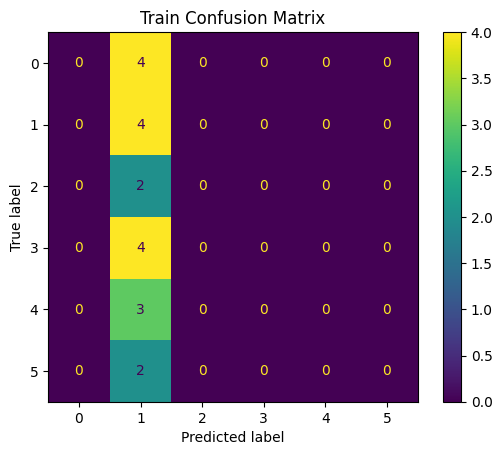

In [35]:
# Train and Test Confusion Matrices
ConfusionMatrix(train_true_labels, train_pred_labels, "Train Confusion Matrix",ohe)

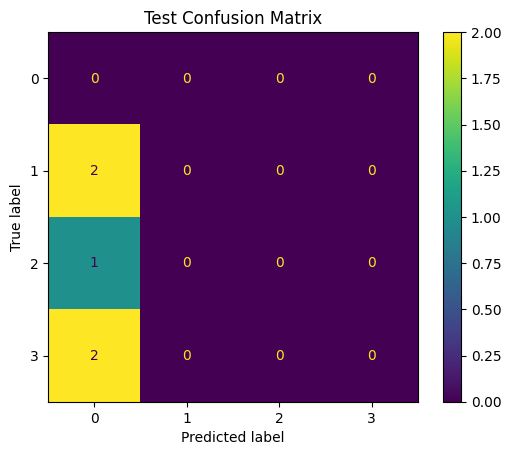

In [36]:
ConfusionMatrix(test_true_labels, test_pred_labels, "Test Confusion Matrix",ohe)

In [42]:
# Save the model
classification_model.save('BERT_Cased_Classification_Model.h5') #custom_objects={'TFBertModel': TFBertModel}) # 'bert_classification_model.h5'

In [62]:
# Save the model
classification_model.save('BERT_Cased_Classification_Model.h5')

# Create a separate directory to save the tokenizer
tokenizer.save_pretrained('BERT_Tokenizer')

# Save the OneHotEncoder
joblib.dump(ohe, 'OneHotEncoder.pkl')

['OneHotEncoder.pkl']

#### Out of sample data

In [63]:
# Load the model
ClassificationBERTModel = tf.keras.models.load_model(
    'BERT_Cased_Classification_Model.h5',
    custom_objects={'TFBertModel': TFBertModel}  # Register the custom object
)

#Load Saved Tokenizer
tokenizer = BertTokenizer.from_pretrained('BERT_Tokenizer')

# Load the OneHotEncoder
ohe = joblib.load('OneHotEncoder.pkl')


In [82]:
# Load Data
Val_data = df_out_of_sample.copy()
labels_Val_data = labels_out_of_sample.copy()
Val_data.shape

(6, 2)

In [83]:
#Preprocess Data
Val_data['cleaned_data'] = clean_column(Val_data, 'EXCERPT') 
print(Val_data.shape)
Val_data.head(4)

(6, 3)


,ID,EXCERPT,cleaned_data
1,102,India vs Bangladesh: Surrounded by the ravines...,India vs Bangladesh Surrounded ravines Bihad G...
27,603,Marburg Virus Update: East Africa Heightens Su...,Marburg Virus Update East Africa Heightens Sur...
14,305,"PM Modi, BJP use government machinery for poll...",PM Modi BJP use government machinery poll camp...
19,405,Wall Street Week Ahead: Investors look to earn...,Wall Street Week Ahead Investors look earnings...


In [85]:
# Prepare out-of-time data
X1_input_ids_val = np.zeros((len(Val_data), 50))                           
X1_attn_masks_val = np.zeros((len(Val_data), 50))
X1_input_ids_val, X1_attn_masks_val = generate_data(Val_data, X1_input_ids_val, X1_attn_masks_val)


 Total Number of text tokenized :  6


In [86]:
#Encode Target Variable
labels_Val_data_encoded = ohe.transform(labels_Val_data.to_frame())
labels_Val_data_encoded

C:\Users\wwwtu\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but OneHotEncoder was fitted without feature names
  warnings.warn(


array([[0., 0., 0., 0., 0., 1.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [1., 0., 0., 0., 0., 0.]])

In [98]:
#Define Batch Size for predictions
batch_size = 1

#Create Keras Dataset
Val_dataset = tf.data.Dataset.from_tensor_slices((
    {
        'input_ids': X1_input_ids_val,
        'attention_mask': X1_attn_masks_val
    },
    labels_Val_data_encoded
)).batch(batch_size, drop_remainder=True)

In [93]:
# Val_true_labels_arr = np.array([list(y.numpy()) for _,_,y  in Val_dataset])
# Val_true_labels_arr

array([[0., 0., 0., 0., 0., 1.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [1., 0., 0., 0., 0., 0.]])

In [99]:
#True Val Labels
true_Val_Labels = labels_Val_data.to_list()
true_Val_Labels

['Sports', 'Health', 'Politics', 'Finance', 'Minerals', 'Cinema']

In [104]:
Pred_Val_Labels = Make_Predictions(ClassificationBERTModel, Val_dataset,ohe)
df_out_of_sample['Predicted'] = Pred_Val_Labels
Pred_Val_Labels

6/6 [==============================] - 1s 104ms/step


array(['Finance', 'Finance', 'Finance', 'Finance', 'Finance', 'Finance'],
      dtype=object)

In [101]:
# Evaluate out-of-time data predictions
print("Out-of-sample evaluation")
classes = classes = ohe.categories_[0]                   #list(np.unique(labels_out_of_sample))
print(classification_report(true_Val_Labels, Pred_Val_Labels, target_names=classes))

Out-of-sample evaluation
              precision    recall  f1-score   support

      Cinema       0.00      0.00      0.00         1
     Finance       0.17      1.00      0.29         1
      Health       0.00      0.00      0.00         1
    Minerals       0.00      0.00      0.00         1
    Politics       0.00      0.00      0.00         1
      Sports       0.00      0.00      0.00         1

    accuracy                           0.17         6
   macro avg       0.03      0.17      0.05         6
weighted avg       0.03      0.17      0.05         6



C:\Users\wwwtu\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\wwwtu\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\wwwtu\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

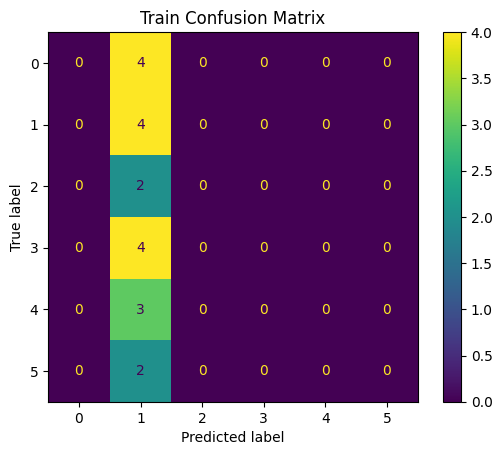

In [103]:
#Plot Confusion Matrix
ConfusionMatrix(train_true_labels, train_pred_labels, "Train Confusion Matrix",ohe)

In [106]:
df_out_of_sample['Actual'] = labels_out_of_sample
df_out_of_sample

,ID,EXCERPT,Predicted,Actual
1,102,India vs Bangladesh: Surrounded by the ravines...,Finance,Sports
27,603,Marburg Virus Update: East Africa Heightens Su...,Finance,Health
14,305,"PM Modi, BJP use government machinery for poll...",Finance,Politics
19,405,Wall Street Week Ahead: Investors look to earn...,Finance,Finance
24,505,Indians across all age groups deficient in iro...,Finance,Minerals
8,204,Nawazuddin Siddiqui mocks mindless action film...,Finance,Cinema


In [ ]:

#^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
# Load your dataset
df = pd.read_excel('data.xlsx') 

X = df_Orig.loc[:,df_Orig.columns != 'TAG']
y = df_Orig['TAG']
#^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

# Train-test split using out-of-sample
df_in_sample, df_out_of_sample, labels_in_sample, labels_out_of_sample = train_test_split(X, y, test_size=0.2, random_state=42, stratify= y)

del X,y

# Store indices
df_in_sample['original_index'] = df_in_sample.index  # Save original indexes

#^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
# Preprocess data 
# Do not make text lower cased as using case sensitive model of bert

df_in_sample['cleaned_data'] = clean_column(df, 'text_column') 
#^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

# Prepare input IDs and attention masks
X_input_ids = np.zeros((len(df_in_sample), 512))                            #If want to apply on the discription column then 512 need to increase
X_attn_masks = np.zeros((len(df_in_sample), 512))
X_input_ids, X_attn_masks = generate_data(df_in_sample, X_input_ids, X_attn_masks)

print(X_input_ids.shape)  # Output: (num_samples, 512) / (nrow_of_data,512)
print(X_attn_masks.shape)  # Output: (num_samples, 512) / (nrow_of_data,512)

#^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
#Label One Hot Encoding
ohe = OneHotEncoder(sparse=False)
# Apply One-Hot Encoding to the 'TAG' column and convert it to an array
labels_in_sample_encoded = ohe.fit_transform(labels_in_sample).toarray()
# 'labels' is now a NumPy array where each row corresponds to the one-hot encoded vector for the 'TAG'
print(labels_in_sample_encoded.shape)  # labels.shape = (num_samples,)

#^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
# Create TensorFlow dataset  from the input arrays with indexes
dataset = tf.data.Dataset.from_tensor_slices((X_input_ids, X_attn_masks, labels_in_sample_encoded, df_in_sample['original_index'].values))


# Take a sample (first batch) from the dataset
for input_ids, attn_mask, label in dataset.take(1):
    print(f"Input IDs: {input_ids.numpy()}")
    print(f"Attention Mask: {attn_mask.numpy()}")
    print(f"Label: {label.numpy()}")

#^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

# Add prefetching to the dataset
dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)
    
#^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
#Splitting data into train and test
# Calculate train size (80% of the In_ Sample_dataset)
train_size = int(len(df_in_sample) * 0.8)

# Create training and testing datasets 
train_dataset = dataset.take(train_size).shuffle(buffer_size=1000).batch(32, drop_remainder=True)  # First 80% for training
test_dataset = dataset.skip(train_size).batch(32, drop_remainder=True)  # Remaining 20% for testing

# Print the sizes of the datasets
print(f"Training dataset size: {len(list(train_dataset))}")  # Convert to list to count
print(f"Testing dataset size: {len(list(test_dataset))}")    # Convert to list to count

#^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
# Obtaining training and Testing data Index and then train and test true labels
train_indexes = [example[3].numpy() for example in train_dataset]
train_true_labels = labels_in_sample[train_indexes]
test_indexes = [example[3].numpy() for example in test_dataset]
test_true_labels = labels_in_sample[test_indexes]

#>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
# #Optional we can find true Labels using following Code
# # 1. Extract the true labels from the train dataset
# train_true_labels1 = np.concatenate([y for _, y in train_dataset], axis=0)  # true labels in one array

# # 2. Extract the true labels from the test dataset
# test_true_labels1 = np.concatenate([y for _, y in test_dataset], axis=0)  # true labels in one array
#>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>

#^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

# Model definition

# Load pre-trained BERT model
# bert_model = transformers.from_pretrained('bert-base-cased')
bert_model = TFBertModel.from_pretrained('bert-base-cased')

# Define the input layers
input_ids = tf.keras.layers.Input(shape=(512,), name='input_ids', dtype='int32')
attn_masks = tf.keras.layers.Input(shape=(512,), name='attention_mask', dtype='int32')

# Get the BERT embeddings (pooled output [CLS] token)
bert_embds = bert_model(input_ids, attention_mask=attn_masks)[1]

# Dropout layer after BERT output
dr_layer = tf.keras.layers.Dropout(0.2, name='dropout1')(bert_embds)

# Intermediate Dense layer
intermediate_layer = tf.keras.layers.Dense(512, activation='relu', name='intermediate_layer')(dr_layer)

# Another Dropout layer after intermediate layer
dr_layer = tf.keras.layers.Dropout(0.2, name='dropout2')(intermediate_layer)

# Output layer for classification (9 classes, softmax activation)
output_layer = tf.keras.layers.Dense(labels.shape[1], activation='softmax', name='output_layer')(dr_layer)

# Define the classification model
classification_model = tf.keras.Model(inputs=[input_ids, attn_masks], outputs=output_layer)

# Define the Optimizer, Loss Function and Metrics to evaluate
classification_model.compile(optimizer=tf.keras.optimizers.Adam(),
                             loss='categorical_crossentropy',
                             metrics=['accuracy', tf.keras.metrics.Precision()]))
            #It calculates precision after each batch,might leads slightly different results than on the whole dataset after training.
#>>>>>>>>>>>>>>>>>>>>
#Optional Part
# # Callbacks for early stopping and model checkpoint
# early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)
# checkpoint = tf.keras.callbacks.ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True)
#>>>>>>>>>>>>>>>>>>>>

# Show the model summary
classification_model.summary()
 
#^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
#>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
#Optional

# # Model training with callbacks
# classification_model.fit(
#     train_dataset, 
#     validation_data=test_dataset, 
#     epochs=3, 
#     callbacks=[early_stopping, checkpoint],
#     batch_size=32  # Even though it's already defined in the dataset
# )
#>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>

# Model training without callbacks
classification_model.fit(
    train_dataset, 
    validation_data=test_dataset, 
    epochs=3
)

#^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


# Evaluation
train_loss, train_accuracy, train_precision_keras  = classification_model.evaluate(train_dataset)
test_loss, test_accuracy, test_precision_keras = classification_model.evaluate(test_dataset)
#>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> OPTIONAL
# print(f"Train Loss: {train_loss}, Train Accuracy: {train_accuracy}, Train Preci Keras: {train_precision_keras}")
# print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}, Test Preci keras: {test_precision_keras}")
#>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>

# Make Predictions for both training and testing data

#>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
# # optional function if anyone want to make predictions in batches
# def Make_Batch_Predictions(classification_model, dataset, batch_size=32):
#     # Initialize a list to hold predictions
#     all_pred_labels = []

#     # Iterate over the dataset in batches
#     for batch in dataset:
#         # Get predictions from the model (logits/probabilities)
#         preds = classification_model.predict(batch[0], batch_size=batch_size)  # Predict only on inputs
#         # Convert predictions to class labels (argmax to get the predicted class)
#         pred_labels = np.argmax(preds, axis=1)
#         # Append the predictions to the list
#         all_pred_labels.extend(pred_labels)

#     # Convert the list to a numpy array
#     return np.array(all_pred_labels)
#>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>

#Training and Testing Predictions
train_pred_labels = Make_Predictions(classification_model, train_dataset)
test_pred_labels = Make_Predictions(classification_model, test_dataset)

# Cross-check with true labels
for i in range(5):  # Checking the first 5 entries
    print(f"Train True: {train_true_labels[i]}, Train Predicted: {train_pred_labels[i]}")
    print(f"Test True: {test_true_labels[i]}, Test Predicted: {test_pred_labels[i]}")

# Calculating manual Precision
train_precision_Man = Precision_Manually(train_true_labels, train_pred_labels)
test_precision_Man = Precision_Manually(test_true_labels, test_pred_labels)

print(f"Train Loss: {train_loss}, Train Accuracy: {train_accuracy}, Train Preci Manually: {train_precision_Man},Train Preci Keras: {train_precision_keras}")
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}, Test Preci Manually: {test_precision_Man},Test Preci keras: {test_precision_keras}")
    
# Train and Test Confusion Matrices
plot_confusion_matrix(train_true_labels, train_pred_labels, "Train Confusion Matrix")
plot_confusion_matrix(test_true_labels, test_pred_labels, "Test Confusion Matrix")

# Save the model
classification_model.save('BERT_Cased_Classification_Model.h5') # 'bert_classification_model.h5'




In [ ]:
#for Out-of-Time data
# Save original indexes
df_out_of_sample['original_index'] = df_out_of_sample.index

# Load the model
ClassificationBERTModel = tf.keras.models.load_model('BERT_Cased_Classification_Model.h5', custom_objects={'TFBertModel': TFBertModel})

#Preprocess data


# Prepare out-of-time data
X1_input_ids_val = np.zeros((len(df_out_of_sample), 512))                           
X1_attn_masks_val = np.zeros((len(df_out_of_sample), 512))
X1_input_ids_val, X1_attn_masks_val = generate_data(df_out_of_sample, X1_input_ids, X1_attn_masks)


#>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
#>>>>>>>>>>>>>>>>>>>>>>>>>>FOLLOWING CODE IS USEFUL IF YOU DONT WANT TO CREATE "X_input_ids_val" AND "X_attn_masks_val" SEPERATELY
# def prepare_data(input_text, tokenizer):
#     token = tokenizer.encode_plus(
#         input_text,
#         max_length=512,
#         padding='max_length',
#         truncation=True,
#         return_tensors='tf'
#     )
#     return {'input_ids': tf.cast(token['input_ids'], tf.float64), 'attention_mask': tf.cast(token['attention_mask'], tf.float64)}

# # Make predictions on out-of-time data
# def make_predictions(model, processed_data, classes):
#     probs = model.predict([processed_data['input_ids'], processed_data['attention_mask']])[0]
#     return classes[np.argmax(probs)]
#>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>

#Encode Target Variable
labels_out_of_sample_encoded = ohe.transform(labels_out_of_sample).toarray()

#Create Keras Dataset
Val_dataset = tf.data.Dataset.from_tensor_slices((X1_input_ids, X1_attn_masks, labels_out_of_sample_encoded, df_out_of_sample['original_index'].values))

#True Val Labels
Val_true_labels_arr = np.concatenate([y for _, y in Val_dataset], axis=0)  # true labels in one array
# Convert OHE arrays back to original labels
Val_true_labels = ohe.inverse_transform(Val_true_labels_arr)

#>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
Val_pred_labels = Make_Predictions(ClassificationBERTModel, Val_dataset)

df_out_of_sample['predicted'] = Val_pred_labels

# Evaluate out-of-time data predictions
print("Out-of-sample evaluation")
classes = classes = ohe.categories_[0]                   #list(np.unique(labels_out_of_sample))
print(classification_report(Val_true_labels, Val_pred_labels, target_names=classes))

plot_confusion_matrix(train_true_labels, train_pred_labels, "Train Confusion Matrix")





# # Classes for prediction
# classes = list(np.unique(df['TAG']))
# test_excerpts = df_out_of_sample['cleaned_data'].to_list()

# predicted = []
# for text in test_excerpts:
#     processed_data = prepare_data(text, tokenizer)
#     result = make_predictions(NewsClassificationBERTModel, processed_data, classes=classes)
#     predicted.append(result)

    
    
# df_out_of_sample['predicted'] = predicted

# # Evaluate out-of-time data predictions
# print("Out-of-sample evaluation")
# print(classification_report(df_out_of_sample['TAG'], df_out_of_sample['predicted'], target_names=classes))
